# Analysis of Linux Logs to detect Anomalies

In [45]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# @title Importing needed libraries
import pandas as pd
import numpy as np
import json
from pandas import json_normalize
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import random

## Parsing Logs
Journalctl can just retrieve logs in Json, Is needed to parse the data to Csv and work with it.

In [ ]:
# @title ### Uploading the training content {run:"auto", display-mode:"form"}
# @markdown If you need to change the dir of the train data please do it changing this url
URL_TRAIN_LOGS = '/content/gdrive/MyDrive/SO/Proyecto Final/test_files/all_logs.json' # @param {type:"string"}
with open(URL_TRAIN_LOGS, 'r') as file:
  json_logs = json.load(file)

def common_keys(list_of_dicts):
    if not list_of_dicts:
        return []
    first_dict_keys = set(list_of_dicts[0].keys())
    common_keys_set = set.intersection(*[set(d.keys()) for d in list_of_dicts])
    return list(common_keys_set)

print(common_keys(json_logs))
json_logs[7435]

['__SEQNUM_ID', 'PRIORITY', '_TRANSPORT', '__SEQNUM', '__CURSOR', '__REALTIME_TIMESTAMP', 'MESSAGE', '_HOSTNAME', '_RUNTIME_SCOPE', '__MONOTONIC_TIMESTAMP', '_BOOT_ID', '_MACHINE_ID']


{'_BOOT_ID': '8bc66473fa424f79bef59001a24d4715',
 'SYSLOG_IDENTIFIER': 'kernel',
 '__CURSOR': 's=f44a388888234c55b61c551f297a8eae;i=24c202;b=8bc66473fa424f79bef59001a24d4715;m=106f17b05;t=607efacc6af6e;x=18bc6b39e05aa732',
 '__REALTIME_TIMESTAMP': '1697575837544302',
 '__MONOTONIC_TIMESTAMP': '4411456261',
 '_TRANSPORT': 'kernel',
 '__SEQNUM_ID': 'f44a388888234c55b61c551f297a8eae',
 '_RUNTIME_SCOPE': 'system',
 '_SOURCE_MONOTONIC_TIMESTAMP': '4411504273',
 '__SEQNUM': '2408962',
 'PRIORITY': '6',
 'SYSLOG_FACILITY': '0',
 'MESSAGE': 'Bluetooth: hci0: Applying Intel DDC parameters completed',
 '_MACHINE_ID': 'f705564391394bb9bb636b876f8056eb',
 '_HOSTNAME': 'Radiant'}

### Selecting important parameters and cleaning the data
Before parsing logs there's something to do. To select which parameters will be important to the model.

In this case these parameters will be:
- **PRIORITY:** indicates how important is is the log entry.
- **_TRANSPORT:** specifies the transport protocol which could be *kernel*, *journal*, *syslog*, etc...
- **MESSAGE:** the actual log message.
- **_RUNTIME_SCOPE:** Where the log ocurred.
- **_BOOT_ID:** identifies the boot session.

It's almost obvious why each one of these have been selected.

So... knowing the selected parameters it's time to clean the data

In [ ]:
# @title Cleaning data
clean_log_entry = lambda log_entry : {
      'priority': log_entry['PRIORITY'],
      'transport': log_entry['_TRANSPORT'],
      'scope': log_entry['_RUNTIME_SCOPE'],
      'boot_id': log_entry['_BOOT_ID'],
      'message': log_entry['MESSAGE'] if log_entry['MESSAGE'] else 'none'
  }

def clean_logs(logs):
  return [clean_log_entry(entry) for entry in logs]

cleaned_logs = clean_logs(json_logs)
cleaned_logs[0]

{'priority': '6',
 'transport': 'kernel',
 'scope': 'system',
 'boot_id': '307390e47721444693e132cdb1d29936',
 'message': '/var/log/journal/f705564391394bb9bb636b876f8056eb/user-1000.journal: Journal file uses a different sequence number ID, rotating.'}

In [ ]:
# @title Defining criteria {run:"auto", display-mode:"form"}
# @markdown Define threshold of the priority:
anomaly_priority_threshold = 4 # @param {type:"slider", min:0, max:7, step:1}
# @markdown Define which keywords mean an exception:
error_keywords = "critical,error,dumped,problem,unable,failed,status 1,fault,corrupt,fatal,crash" # @param {type:"string"}
error_keywords = error_keywords.split(',')
exception_keywords = "exception,warning,potential issue,alert,risk,caution,advisory" # @param {type:"string"}
exception_keywords = exception_keywords.split(',')
transport_keywords = "kernel,syslog,journal,stderr" # @param {type:"string"}
transport_keywords = transport_keywords.split(',')

In [ ]:
# @title Labeling important information
class_names = ['No Anomaly', 'Low Anomaly', 'Medium Anomaly', 'High Anomaly']
def label_entry_log(entry):
  label = {}
  anomaly = 0

  max_anomaly = int(entry['priority']) <= anomaly_priority_threshold and \
    any([keyword in entry['transport'].lower() for keyword in transport_keywords]) and \
    (any([keyword in entry['message'].lower() for keyword in error_keywords]) or \
      any([keyword in entry['message'].lower() for keyword in exception_keywords]))

  medium_anomaly = (any([keyword in entry['message'].lower() for keyword in error_keywords]) or \
      any([keyword in entry['message'].lower() for keyword in exception_keywords])) and \
    any([keyword in entry['transport'].lower() for keyword in transport_keywords])

  low_anomaly = (any([keyword in entry['message'].lower() for keyword in error_keywords]) or \
      any([keyword in entry['message'].lower() for keyword in exception_keywords]))

  if max_anomaly: anomaly = 3
  elif medium_anomaly: anomaly = 2
  elif low_anomaly: anomaly = 1

  label['anomaly'] = anomaly
  return label

def label_logs(logs):
  return [label_entry_log(entry) for entry in logs]

labels = label_logs(cleaned_logs)

## Features of the model
Once data is formatted you can start to create the model, this step is that.

In [ ]:
df = pd.json_normalize(cleaned_logs)

# Assuming 'labels' is a list of dictionaries containing labels
labels = shuffle(labels, random_state=42)

# Concatenate all fields into a single string in each log entry
df['logs'] = df.apply(lambda row: ' '.join(map(str, row)), axis=1)

# Extract the concatenated log entries as text features
features = df['logs'].astype(str)

# Extract labels
anomaly_labels = [label['anomaly'] for label in labels]

In [ ]:
# @title Spliting in train and test datasets and setting class_weights
# Split the data into training and testing sets
train_features, test_features, train_anomaly_labels, test_anomaly_labels = train_test_split(
    features, anomaly_labels, test_size=0.2, random_state=42
)
# Set class weights
class_weights = {0: 1, 1: 10, 2: 34, 3: 53}  # Adjust the weights as needed

## Random Forest Classifier

In [ ]:
# @title RandomForestClassifier configuration
# Use TF-IDF vectorization within a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('clf_anomaly', RandomForestClassifier(random_state=42, class_weight=class_weights)),
])

# Define hyperparameters to tune
param_grid = {
    'clf_anomaly__n_estimators': [10],
    'clf_anomaly__max_depth': [5],
    'clf_anomaly__min_samples_split': [4],
    'clf_anomaly__min_samples_leaf': [4]
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=4)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


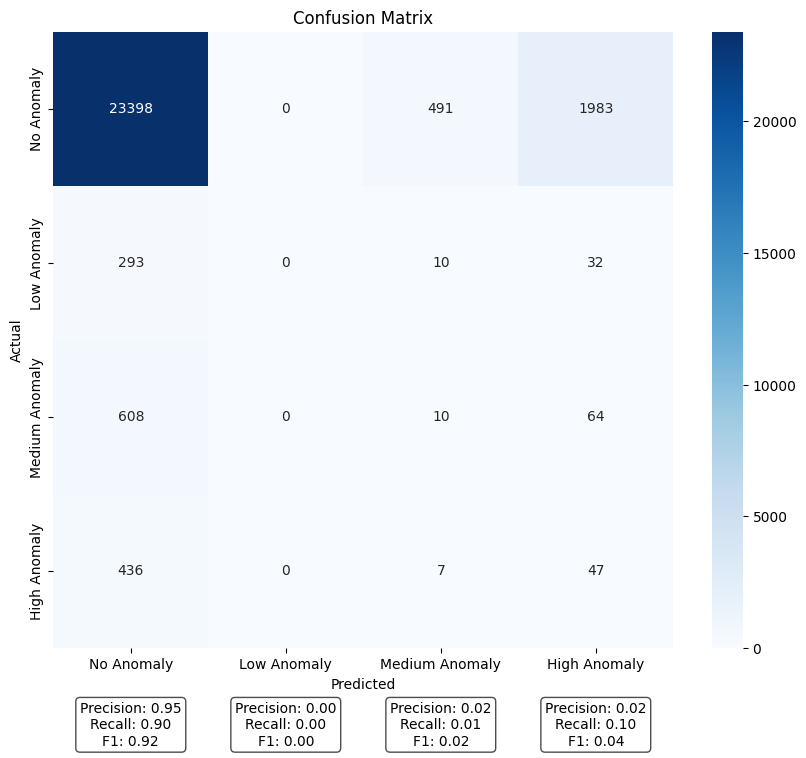

Anomaly Model Accuracy: 0.86
Anomaly Model Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92     25872
           1       1.00      0.00      0.00       335
           2       0.02      0.01      0.02       682
           3       0.02      0.10      0.04       490

    accuracy                           0.86     27379
   macro avg       0.50      0.25      0.24     27379
weighted avg       0.91      0.86      0.87     27379



In [ ]:
# @title RandomForest Model Training

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)

    for i in range(len(classes)):
        plt.text(i + 0.5, len(classes) + 0.5, f'Precision: {precision[i]:.2f}\nRecall: {recall[i]:.2f}\nF1: {f1[i]:.2f}',
                 ha='center', va='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

    plt.show()



grid_search.fit(train_features, train_anomaly_labels)

# Make predictions
anomaly_predictions = grid_search.predict(test_features)

# Evaluate the model
anomaly_accuracy = accuracy_score(test_anomaly_labels, anomaly_predictions)
anomaly_classification_report = classification_report(test_anomaly_labels, anomaly_predictions, zero_division=1)

plot_confusion_matrix(test_anomaly_labels, anomaly_predictions, classes=class_names)
print(f'Anomaly Model Accuracy: {anomaly_accuracy:.2f}')
print('Anomaly Model Classification Report:')
print(anomaly_classification_report)

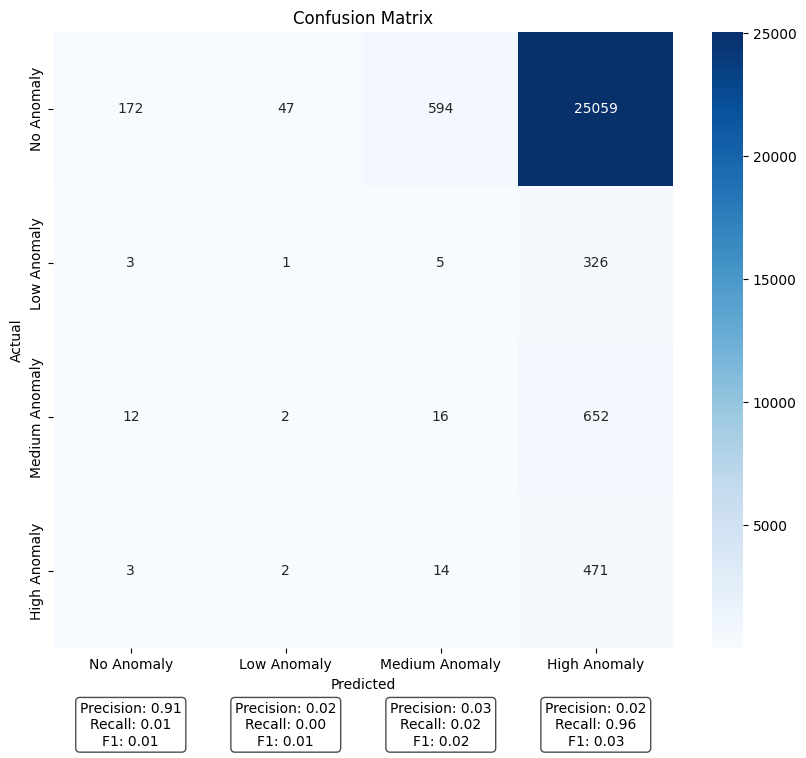

Anomaly Model Accuracy: 0.02
Anomaly Model Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.01      0.01     25872
           1       0.02      0.00      0.01       335
           2       0.03      0.02      0.02       682
           3       0.02      0.96      0.03       490

    accuracy                           0.02     27379
   macro avg       0.24      0.25      0.02     27379
weighted avg       0.86      0.02      0.01     27379



In [ ]:
# @title RandomForest using RandomOverSampler
def reshape_data(train_features):
    train_features_array = train_features.to_numpy()
    return train_features_array.reshape(-1, 1)

def split_data(features, anomaly_labels):
    return train_test_split(features, anomaly_labels, test_size=0.2, random_state=42)

def oversample_data(train_features_2d, train_anomaly_labels):
    ros = RandomOverSampler(random_state=42)
    return ros.fit_resample(train_features_2d, train_anomaly_labels)

def reshape_to_1d(data):
    return np.squeeze(data)

def tfidf_vectorization(train_features_resampled, test_features):
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    train_features_tfidf = tfidf_vectorizer.fit_transform(train_features_resampled)
    test_features_tfidf = tfidf_vectorizer.transform(test_features)
    return train_features_tfidf, test_features_tfidf

def train_random_forest(train_features_tfidf, train_anomaly_labels_resampled, class_weights):
    clf_anomaly = RandomForestClassifier(random_state=42, class_weight=class_weights, n_estimators=40, max_depth=20)
    clf_anomaly.fit(train_features_tfidf, train_anomaly_labels_resampled)
    return clf_anomaly

def evaluate_model(test_anomaly_labels, anomaly_predictions, class_names):
    anomaly_accuracy = accuracy_score(test_anomaly_labels, anomaly_predictions)
    anomaly_classification_report = classification_report(test_anomaly_labels, anomaly_predictions, zero_division=1)

    print(f'Anomaly Model Accuracy: {anomaly_accuracy:.2f}')
    print('Anomaly Model Classification Report:')
    print(anomaly_classification_report)

class_weights = {0: 2, 1: 10, 2: 25, 3: 45}

# Preparing Data
train_features_2d = reshape_data(train_features)
train_features, test_features, train_anomaly_labels, test_anomaly_labels = split_data(features, anomaly_labels)
train_features_resampled, train_anomaly_labels_resampled = oversample_data(train_features_2d, train_anomaly_labels)
train_features_resampled = reshape_to_1d(train_features_resampled)
train_features_tfidf, test_features_tfidf = tfidf_vectorization(train_features_resampled, test_features)

#Training
clf_anomaly = train_random_forest(train_features_tfidf, train_anomaly_labels_resampled, class_weights)
anomaly_predictions = clf_anomaly.predict(test_features_tfidf)

# Evaluating
plot_confusion_matrix(test_anomaly_labels, anomaly_predictions, classes=class_names)
evaluate_model(test_anomaly_labels, anomaly_predictions, class_names)


# LogisticRegression Model

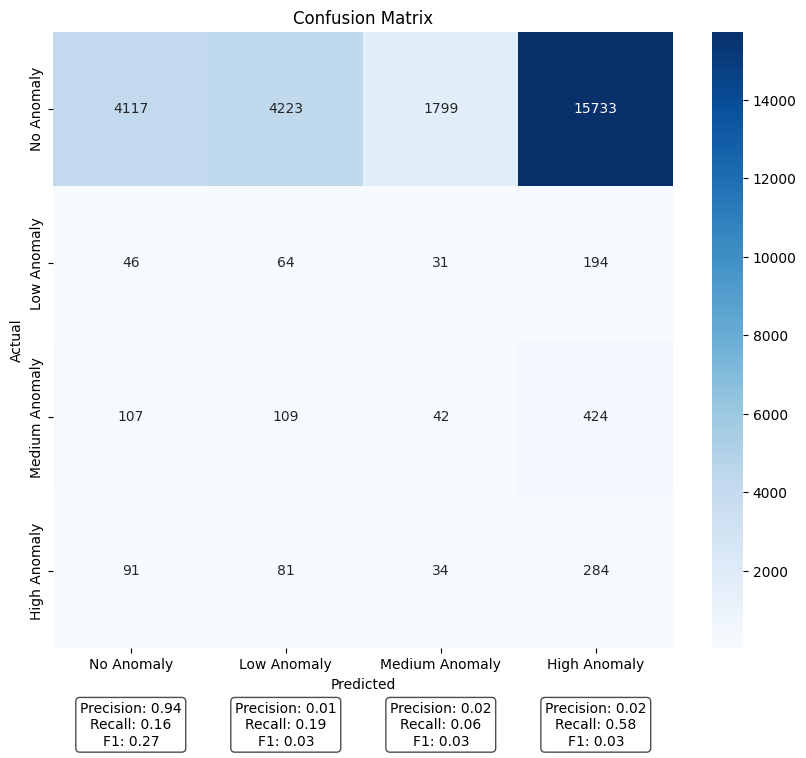

Anomaly Model Accuracy: 0.16
Anomaly Model Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.16      0.27     25872
           1       0.01      0.19      0.03       335
           2       0.02      0.06      0.03       682
           3       0.02      0.58      0.03       490

    accuracy                           0.16     27379
   macro avg       0.25      0.25      0.09     27379
weighted avg       0.89      0.16      0.26     27379



In [ ]:
scaler = StandardScaler(with_mean=False)

# Function to oversample minority class
def oversample_minority_class(features, labels):
    oversampler = RandomOverSampler(random_state=42)
    features_resampled, labels_resampled = oversampler.fit_resample(features, labels)
    return features_resampled, labels_resampled

# Function for text vectorization using CountVectorizer
def vectorize_text(features):
    vectorizer = CountVectorizer(max_features=1000)
    features_vectorized = vectorizer.fit_transform(features)
    return features_vectorized

# Function to train a model
def train_model(features_train, labels_train):
    features_train_scaled = scaler.fit_transform(features_train)
    model = LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear')
    model.fit(features_train_scaled, labels_train)
    return model

# Function to make predictions using a trained model
def predict(model, features_test):
    features_test_scaled = scaler.transform(features_test)

    predictions = model.predict(features_test)
    return predictions

# Oversample minority class
train_features_resampled, train_anomaly_labels_resampled = oversample_minority_class(
    vectorize_text(train_features), train_anomaly_labels
)

# Train the model
trained_model = train_model(train_features_resampled, train_anomaly_labels_resampled)

# Vectorize test features
test_features_vectorized = vectorize_text(test_features)

# Make predictions
predictions = predict(trained_model, test_features_vectorized)

# Evaluate the model
anomaly_accuracy = accuracy_score(test_anomaly_labels, predictions)
anomaly_classification_report = classification_report(test_anomaly_labels, predictions, zero_division=1)

plot_confusion_matrix(test_anomaly_labels, predictions, classes=class_names)
print(f'Anomaly Model Accuracy: {anomaly_accuracy:.2f}')
print('Anomaly Model Classification Report:')
print(anomaly_classification_report)

## XGBoost Model

Fitting 4 folds for each of 1 candidates, totalling 4 fits


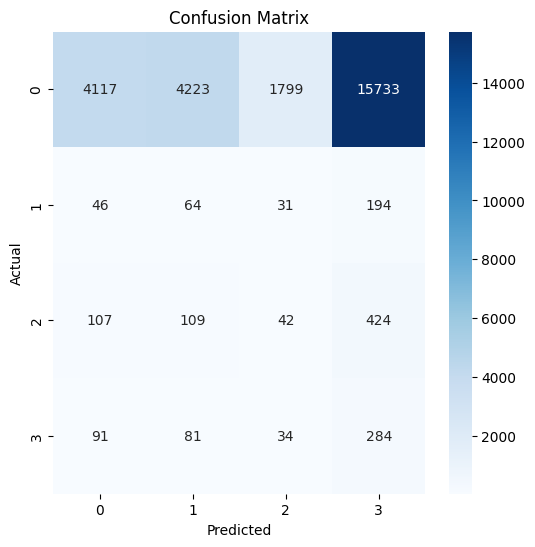

Tuned XGBoost Anomaly Model Accuracy: 0.31
Tuned XGBoost Anomaly Model Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.32      0.47     25872
           1       0.01      0.24      0.02       335
           2       0.02      0.21      0.04       682
           3       0.02      0.17      0.03       490

    accuracy                           0.31     27379
   macro avg       0.25      0.23      0.14     27379
weighted avg       0.90      0.31      0.45     27379



In [ ]:
def extract_features_labels(df, labels):
    features = df['logs'].astype(str)
    anomaly_labels = [label['anomaly'] for label in labels]
    return features, anomaly_labels

def split_data(features, anomaly_labels, test_size=0.2, random_state=42):
    return train_test_split(features, anomaly_labels, test_size=test_size, random_state=random_state)

def set_class_weights(train_anomaly_labels):
    class_weights = compute_class_weight('balanced', classes=np.unique(train_anomaly_labels), y=train_anomaly_labels)
    return {i: class_weights[i] for i in range(len(class_weights))}

def resample_data(train_features, train_anomaly_labels):
    oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
    train_features_resampled, train_anomaly_labels_resampled = oversampler.fit_resample(
        train_features.values.reshape(-1, 1), train_anomaly_labels
    )
    return train_features_resampled.flatten(), train_anomaly_labels_resampled

def vectorize_text_features(train_features_resampled, test_features):
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    train_features_tfidf = tfidf_vectorizer.fit_transform(train_features_resampled)
    test_features_tfidf = tfidf_vectorizer.transform(test_features)
    return train_features_tfidf, test_features_tfidf

def hyperparameter_tuning(param_grid, xgboost_model, train_features_tfidf, train_anomaly_labels_resampled):
    grid_search = GridSearchCV(xgboost_model, param_grid, cv=4, verbose=2, n_jobs=-1)
    grid_search.fit(train_features_tfidf, train_anomaly_labels_resampled)
    return grid_search.best_params_

def train_tuned_xgboost_model(xgboost_model, best_params, train_features_tfidf, train_anomaly_labels_resampled):
    xgboost_model_tuned = XGBClassifier(
        objective='multi:softmax',
        eval_metric='mlogloss',
        num_class=len(np.unique(train_anomaly_labels)),
        random_state=42,
        **best_params,
    )
    xgboost_model_tuned.fit(train_features_tfidf, train_anomaly_labels_resampled)
    return xgboost_model_tuned

def evaluate_xgboost_model(model, test_features_tfidf, test_anomaly_labels):
    predictions = model.predict(test_features_tfidf)
    accuracy = accuracy_score(test_anomaly_labels, predictions)
    classification_report_str = classification_report(test_anomaly_labels, predictions, zero_division=1)
    print(f'Tuned XGBoost Anomaly Model Accuracy: {accuracy:.2f}')
    print('Tuned XGBoost Anomaly Model Classification Report:')
    print(classification_report_str)

features, anomaly_labels = extract_features_labels(df, labels)

# Preparing Data
train_features, test_features, train_anomaly_labels, test_anomaly_labels = split_data(features, anomaly_labels)
class_weights = set_class_weights(train_anomaly_labels)
train_features_resampled, train_anomaly_labels_resampled = resample_data(train_features, train_anomaly_labels)
train_features_tfidf, test_features_tfidf = vectorize_text_features(train_features_resampled, test_features)

# Define hyperparameters to tune
param_grid = {
    'max_depth': [8],
    'min_child_weight': [6],
    'subsample': [1.0],
    'colsample_bytree': [0.8],
    'learning_rate': [0.2],
}

# Create XGBoost model
xgboost_model = XGBClassifier(
    objective='multi:softmax',
    eval_metric='mlogloss',
    num_class=len(np.unique(train_anomaly_labels)),
    random_state=42,
)

# Hyperparameter tuning
best_params = hyperparameter_tuning(param_grid, xgboost_model, train_features_tfidf, train_anomaly_labels_resampled)

# Train the XGBoost model with the hyperparameters
xgboost_model_tuned = train_tuned_xgboost_model(xgboost_model, best_params, train_features_tfidf, train_anomaly_labels_resampled)

# Evaluate the tuned XGBoost model
plot_confusion_matrix(test_anomaly_labels, predictions, classes=np.unique(test_anomaly_labels))
evaluate_xgboost_model(xgboost_model_tuned, test_features_tfidf, test_anomaly_labels)

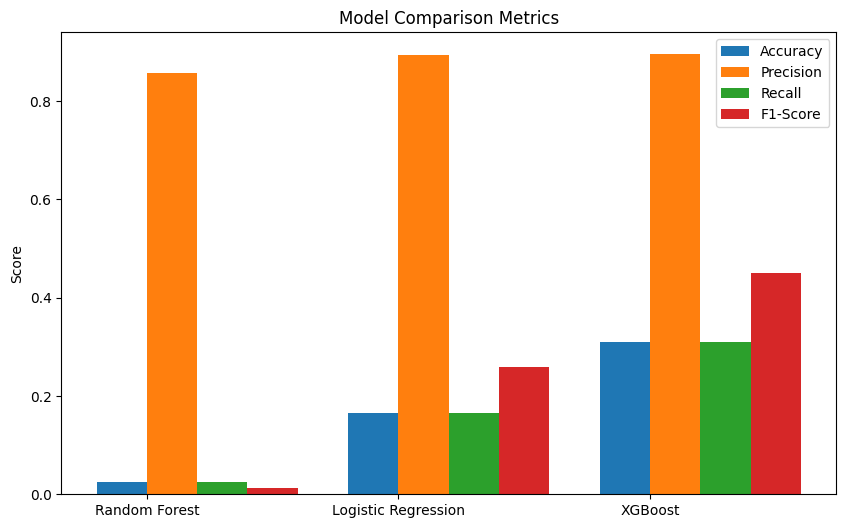

In [ ]:
def plot_model_comparison_bar_chart(models, true_labels, predictions):
    metrics = {
        'Accuracy': accuracy_score,
        'Precision': precision_score,
        'Recall': recall_score,
        'F1-Score': f1_score,
    }

    results = {metric: [] for metric in metrics}

    for model, pred in zip(models, predictions):
        true_label = true_labels[model]
        for metric, metric_func in metrics.items():
            if metric == 'Accuracy':
                score = metric_func(true_label, pred)
            else:
                score = metric_func(true_label, pred, average='weighted')
            results[metric].append(score)

    width = 0.2
    ind = np.arange(len(models))

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, (metric, scores) in enumerate(results.items()):
        ax.bar(ind + i * width, scores, width, label=metric)

    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(models)

    ax.set_ylabel('Score')
    ax.set_title('Model Comparison Metrics')
    ax.legend()

    plt.show()

# Example usage
all_models = ['Random Forest', 'Logistic Regression', 'XGBoost']
all_predictions = [
    anomaly_predictions,
    predictions,
    xgboost_model_tuned.predict(test_features_tfidf),
]
all_true_labels = {
    'Random Forest': test_anomaly_labels,
    'Logistic Regression': test_anomaly_labels,
    'XGBoost': test_anomaly_labels,
}

# Plot the bar chart
plot_model_comparison_bar_chart(all_models, all_true_labels, all_predictions)